### Price Sensitivity Analysis and Optimization

___

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import torch
import torch.nn as nn
import torch.optim as optim


training_data = pd.read_csv("/kaggle/input/e-commerce-synthetic-dataset/ecommerce_synthetic_data.csv")
training_data.head()

/kaggle/input/e-commerce-synthetic-dataset/ecommerce_synthetic_data.csv


,ordered,past_spending,price,quantity,membership_flag,goods_type_clothing,goods_type_eletronics,goods_type_food,goods_type_furniture,goods_type_kichenware,goods_type_medicine,brand_tier_cheap,brand_tier_highend,brand_tier_popular
0,0,1023.73,52.378848,1,0,1,0,0,0,0,0,1,0,0
1,0,0.00,193.436500,2,0,0,1,0,0,0,0,0,1,0
2,0,1873.31,99.014038,5,0,1,0,0,0,0,0,0,1,0
3,0,592.82,355.935818,1,0,0,1,0,0,0,0,0,0,1
4,0,796.50,172.917876,1,1,0,0,0,1,0,0,0,0,1


___
#### Preprocess Training Data

In [2]:
# Good's type column from one-hot encoded columns for stratification
product_info = pd.concat(
    [
        pd.from_dummies(training_data[[x for x in training_data.columns if "goods" in x]], sep="_"),
        pd.from_dummies(training_data[[x for x in training_data.columns if "brand" in x]], sep="_"),
    ],
    axis=1,
)

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    training_data[[x for x in training_data.columns if x != "ordered"]], 
    training_data["ordered"], 
    test_size=0.5, 
    random_state=2024, 
    stratify=product_info,
)

# Features in training set
features_train = X_train[[x for x in X_train.columns if x != "price"]]
features_scaler = StandardScaler().fit(features_train[["past_spending", "quantity"]])
features_train[["past_spending", "quantity"]] = features_scaler.transform(
    features_train[["past_spending", "quantity"]]
)

# Features in testing set
features_test = X_test[[x for x in X_test.columns if x != "price"]]
features_test[["past_spending", "quantity"]] = features_scaler.transform(
    features_test[["past_spending", "quantity"]]
)

In [3]:
price_product_info = pd.concat([training_data["price"], product_info], axis=1)
price_train = price_product_info[price_product_info.index.isin(X_train.index)]
price_test = price_product_info[price_product_info.index.isin(X_test.index)]

price_scalers = {}
for x in price_product_info["goods"].unique():
    price_train_scale = price_train.loc[price_train["goods"] == x, "price"].values.reshape(-1,1)
    price_test_scale = price_test.loc[price_test["goods"] == x, "price"].values.reshape(-1,1)
    # Scale with training prices
    price_scaler = MinMaxScaler().fit(price_train_scale)
    price_train.loc[price_train["goods"] == x, "price"] = price_scaler.transform(price_train_scale)
    price_test.loc[price_test["goods"] == x, "price"] = price_scaler.transform(price_test_scale)
    price_scalers[x] = price_scaler

print("Scaled prices evenly distributed across good's type")
price_test.groupby("goods")["price"].describe().round(3)

Scaled prices evenly distributed across good's type


,count,mean,std,min,25%,50%,75%,max
goods,,,,,,,,
type_clothing,1675.0,0.295,0.202,0.000,0.135,0.259,0.427,1.026
type_eletronics,1652.0,0.373,0.193,0.002,0.222,0.353,0.493,1.026
type_food,1628.0,0.388,0.240,0.001,0.194,0.360,0.551,1.002
type_furniture,1659.0,0.385,0.208,-0.002,0.223,0.361,0.522,1.001
type_kichenware,1732.0,0.379,0.236,-0.000,0.192,0.361,0.551,0.994
type_medicine,1654.0,0.339,0.183,0.006,0.194,0.315,0.450,1.039


In [4]:
# Convert dataframe and numpy array into tensors
features_train_tensor = torch.tensor(features_train.values, dtype=torch.float32)
price_train_tensor = torch.tensor(price_train["price"].values.reshape(-1,1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1,1), dtype=torch.float32)

features_test_tensor = torch.tensor(features_test.values, dtype=torch.float32)
price_test_tensor = torch.tensor(price_test["price"].values.reshape(-1,1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1,1), dtype=torch.float32)

___
#### Train Win Rate Model with Price-Response Function

In [5]:
class MaxWinRateParam(nn.Module):
    def __init__(self):
        super(MaxWinRateParam, self).__init__()
        self.hidden_layer = nn.Linear(12, 5)
        self.output_layer = nn.Linear(5, 1)
        self.sigmoid_activation = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        x = self.sigmoid_activation(x)
        return x


class BiasParam(nn.Module):
    def __init__(self):
        super(BiasParam, self).__init__()
        self.hidden_layer = nn.Linear(12, 5)
        self.tanh_activation = nn.Tanh()
        self.output_layer = nn.Linear(5, 1)
        self.elu_activation = nn.ELU()

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.tanh_activation(x)
        x = self.output_layer(x)
        x = self.elu_activation(x)
        return x


class SensitivityParam(nn.Module):
    def __init__(self):
        super(SensitivityParam, self).__init__()
        self.hidden_layer = nn.Linear(12, 5)
        self.relu_activation = nn.ReLU()
        self.output_layer = nn.Linear(5, 1)

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.relu_activation(x)
        x = self.output_layer(x)
        x = self.relu_activation(x)
        return torch.exp(x) - 1


class WinRateNetwork(nn.Module):
    def __init__(self):
        super(WinRateNetwork, self).__init__()
        self.max_win_rate = MaxWinRateParam()
        self.bias = BiasParam()
        self.sensitivity = SensitivityParam()

    def forward(self, features, price, train=False):
        mul_term = torch.mul(self.sensitivity(features), price)
        add_term = torch.add(self.bias(features), mul_term)
        win_rate = self.max_win_rate(features) / (1 + torch.exp(add_term))
        if train:
            return win_rate
        return (
            win_rate,
            self.max_win_rate(features),
            self.bias(features),
            self.sensitivity(features),
        )

In [6]:
# Training parameters
torch.manual_seed(1234)
n_epochs = 100
batch_size = 256
batches_per_epoch = len(features_train_tensor) // batch_size

# Model settings
model = WinRateNetwork()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(n_epochs):
    if epoch % 10 == 0:
        print(f"Epoch: {epoch + 1}")
    for i in range(batches_per_epoch):
        start = i * batch_size
        X_batch = features_train_tensor[start:(start + batch_size)]
        price_batch = price_train_tensor[start:(start + batch_size)]
        y_batch = y_train_tensor[start:(start + batch_size)]
        # Forward pass
        y_pred = model(X_batch, price_batch, train=True)
        loss = criterion(y_pred, y_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # Update weights

Epoch: 1
Epoch: 11
Epoch: 21
Epoch: 31
Epoch: 41
Epoch: 51
Epoch: 61
Epoch: 71
Epoch: 81
Epoch: 91


___
#### Evaluate the Model

Prediction accuracy at threshold 0.5: 86.52%


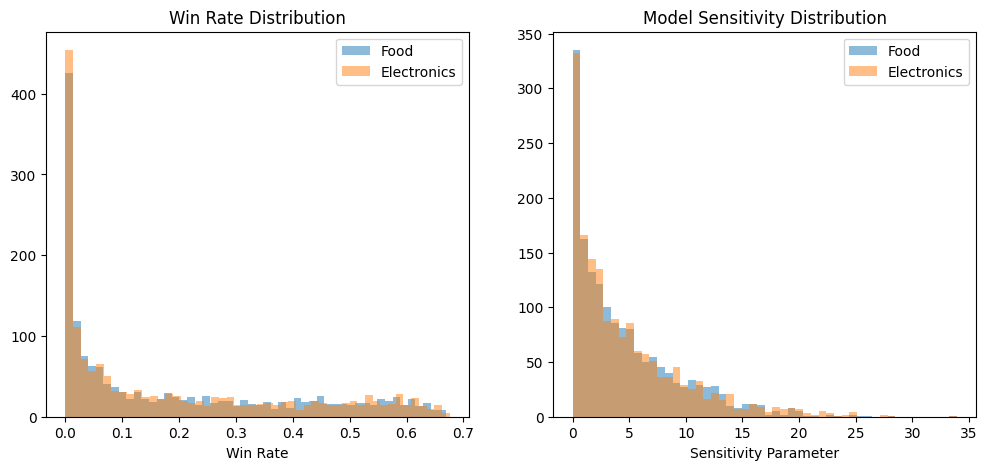

In [7]:
win_rate_test, max_win_rate_test, bias_test, sensitivity_test = model(features_test_tensor, price_test_tensor)

pred_win_rate_test = win_rate_test.detach().numpy()
pred_max_win_rate_test = max_win_rate_test.detach().numpy()
pred_bias_test = bias_test.detach().numpy()
pred_sensitivity_test = sensitivity_test.detach().numpy()

pred_goods_test = pd.concat(
    [
        product_info[product_info.index.isin(X_test.index)].reset_index(), 
        pd.Series(pred_win_rate_test.ravel(), name="predicted_win_rate"),
        pd.Series(pred_sensitivity_test.ravel(), name="predicted_sensitivity"),
    ], 
    axis=1,
)

conversion_accuracy = ((pred_win_rate_test > 0.5).astype(int).ravel() == y_test.values).mean()
print(f"Prediction accuracy at threshold 0.5: {conversion_accuracy:.2%}")

fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].hist(
    pred_goods_test.loc[pred_goods_test["goods"] == "type_food", "predicted_win_rate"], 
    bins=50, alpha=0.5, label="Food"
)
ax[0].hist(
    pred_goods_test.loc[pred_goods_test["goods"] == "type_eletronics", "predicted_win_rate"], 
    bins=50, alpha=0.5, label="Electronics"
)
ax[0].set_title("Win Rate Distribution")
ax[0].set_xlabel("Win Rate")
ax[0].legend()
ax[1].hist(
    pred_goods_test.loc[pred_goods_test["goods"] == "type_food", "predicted_sensitivity"], 
    bins=50, alpha=0.5, label="Food"
)
ax[1].hist(
    pred_goods_test.loc[pred_goods_test["goods"] == "type_eletronics", "predicted_sensitivity"], 
    bins=50, alpha=0.5, label="Electronics"
)
ax[1].set_title("Model Sensitivity Distribution")
ax[1].set_xlabel("Sensitivity Parameter")
ax[1].legend()
plt.show()

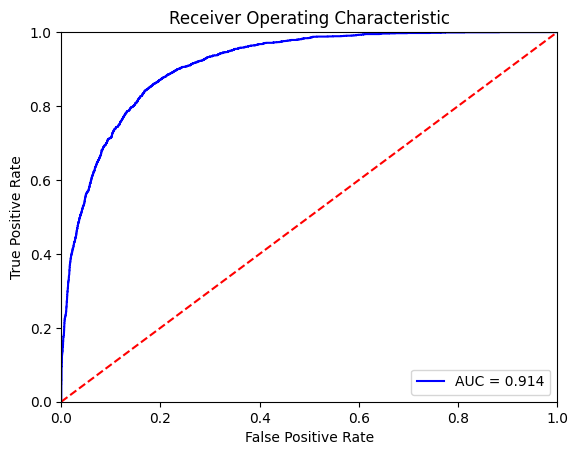

In [8]:
fpr, tpr, threshold = roc_curve(y_test_tensor, pred_win_rate_test)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f"AUC = {roc_auc_score(y_test_tensor, pred_win_rate_test):.3}")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

___
#### Analyze Price-Response Function Parameters

In [9]:
categorical_features_test = pd.concat(
    [
        pd.from_dummies(X_test[[x for x in training_data.columns if "goods_type" in x]], sep="_"),
        pd.from_dummies(X_test[[x for x in training_data.columns if "brand_tier" in x]], sep="_"),
    ],
    axis=1,
).reset_index()

pred_test_params = pd.DataFrame({
    "predicted_win_rate": pred_win_rate_test.ravel(), 
    "max_win_rate_param": pred_max_win_rate_test.ravel(),
    "bias_param": pred_bias_test.ravel(),
    "sensitivity_param": pred_sensitivity_test.ravel(),
})

pred_analysis = pd.concat(
    [
        X_test[["past_spending", "price", "quantity", "membership_flag"]].reset_index(),
        categorical_features_test,
        price_test["price"].reset_index().drop(columns="index").rename(columns={"price": "price_index"}),
        pred_test_params,
    ], 
    axis=1
).drop(columns="index")

pred_analysis.describe().round(3)

,past_spending,price,quantity,membership_flag,price_index,predicted_win_rate,max_win_rate_param,bias_param,sensitivity_param
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,1086.665,121.636,5.461,0.497,0.360,0.191,0.652,0.708,4.542
std,865.351,121.023,2.870,0.500,0.214,0.202,0.192,0.837,4.801
min,0.000,0.317,1.000,0.000,-0.002,0.000,0.110,-0.818,0.000
25%,329.370,40.719,3.000,0.000,0.192,0.015,0.519,-0.015,0.970
50%,1004.610,77.252,5.000,0.000,0.333,0.107,0.677,0.748,3.041
75%,1683.905,161.101,8.000,1.000,0.502,0.342,0.811,1.379,6.572
max,4653.040,746.237,10.000,1.000,1.039,0.684,0.986,2.540,33.934


type_clothing 0.3596779100893949
type_eletronics 0.36388366281468953
type_food 0.3574428806976154
type_furniture 0.36340450028215254
type_kichenware 0.3631892239200241
type_medicine 0.3509751176600855
tier_cheap 0.35656868466885616
tier_highend 0.36160628006501366
tier_popular 0.3612638715232411
0 0.35842878537856865
1 0.3611770991636489


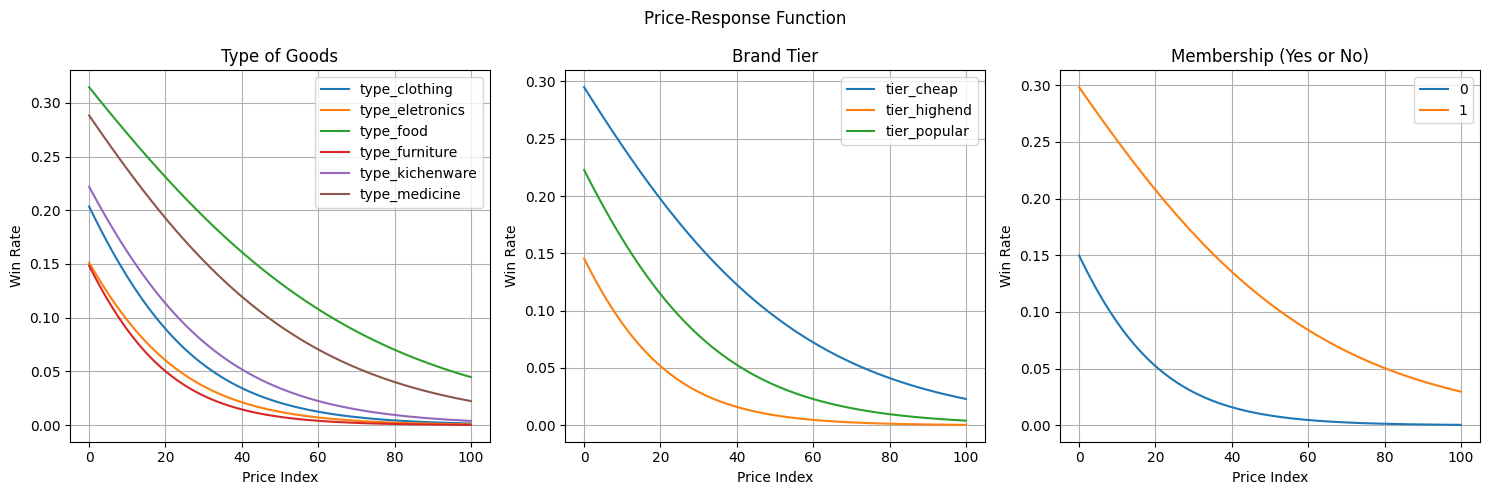

In [10]:
def price_response_function(params, price):
    return params[0] / (1 + np.exp(params[1] + params[2] * price))

def price_response_plot(feature, ax, title):
    avg_params_by_feature = pred_analysis.groupby(feature)[
        ["max_win_rate_param", "bias_param", "sensitivity_param", "predicted_win_rate", "price_index"]
    ].mean()
    for value in avg_params_by_feature.index:
        avg_params = avg_params_by_feature.loc[value].values
        print(value, avg_params[-1])
        prices = np.linspace(0, 1, 101)
        responses = [price_response_function(avg_params[:-1], x) for x in prices]
        ax.plot(responses, label=value)
        ax.set_title(title)
        ax.set_xlabel("Price Index")
        ax.set_ylabel("Win Rate")
    ax.legend()
    ax.grid()
    return avg_params_by_feature

fig, ax = plt.subplots(1,3,figsize=(15,5))

_ = price_response_plot("goods", ax[0], "Type of Goods")
brand_price_response = price_response_plot("brand", ax[1], "Brand Tier")
_ = price_response_plot("membership_flag", ax[2], "Membership (Yes or No)")

plt.suptitle("Price-Response Function")
plt.tight_layout()

Cheap Brand may need 11.2% price change for 0.7% revenue increase
Popular Brand may need -27.4% price change for 6.9% revenue increase
High-end Brand may need -50.1% price change for 42.4% revenue increase


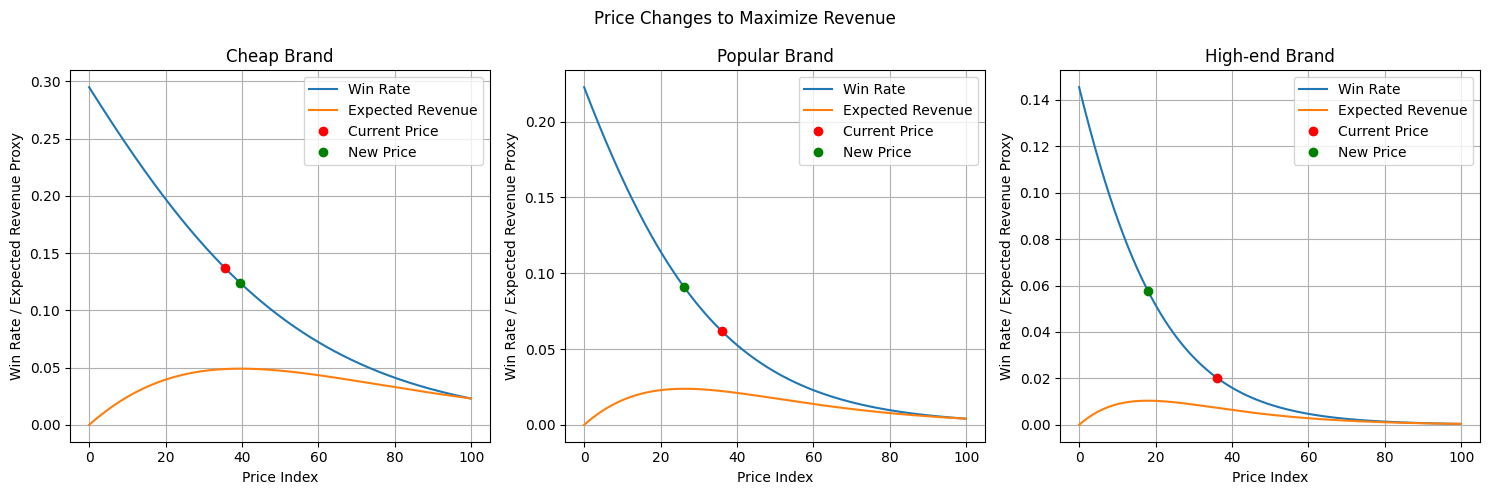

In [11]:
def new_price_expected_revenue(_df, ax, title):
    params = _df[["max_win_rate_param", "bias_param", "sensitivity_param"]].values
    # Calculate win rate and expected revenue
    price_win_rate = [price_response_function(params, x) for x in np.linspace(0, 1, 1000)]
    expected_revenue = price_win_rate * np.linspace(0, 1, 1000)
    # Find current and new price indices
    current_price_index = int(_df["price_index"] * 1000)
    new_price_index = np.argmax(expected_revenue)
    price_change = new_price_index / current_price_index - 1
    expected_revenue_change = expected_revenue[new_price_index] / expected_revenue[current_price_index] - 1
    print(f"{title} may need {price_change:.1%} price change for {expected_revenue_change:.1%} revenue increase")
    ax.plot(price_win_rate, label="Win Rate")
    ax.plot(expected_revenue, label="Expected Revenue")
    ax.plot(current_price_index, price_win_rate[current_price_index], "ro", label="Current Price")
    ax.plot(new_price_index, price_win_rate[new_price_index], "go", label="New Price")
    ax.set_title(title)
    ax.set_xticks(np.arange(0, 1001, 200), np.arange(0, 101, 20))
    ax.set_xlabel("Price Index")
    ax.set_ylabel("Win Rate / Expected Revenue Proxy")
    ax.legend()
    ax.grid()


fig, ax = plt.subplots(1,3,figsize=(15,5))
plt.suptitle("Price Changes to Maximize Revenue")
new_price_expected_revenue(brand_price_response.loc["tier_cheap"], ax[0], "Cheap Brand")
new_price_expected_revenue(brand_price_response.loc["tier_popular"], ax[1], "Popular Brand")
new_price_expected_revenue(brand_price_response.loc["tier_highend"], ax[2], "High-end Brand")
plt.tight_layout()

___
#### Price Optimization

In [12]:
def simulate_price_change(_df, change_rate):
    """Predict win rates with discounted prices"""
    _df["new_price"] = _df["price"] * (1 + change_rate)
    _df["new_price"] = _df.apply(
        lambda x: price_scalers.get(x["goods"]).transform(np.array(x["new_price"]).reshape(1,-1)).ravel()[0], 
        axis=1,
    )
    price_tensor = torch.tensor(_df["new_price"].values.reshape(-1,1), dtype=torch.float32)
    
    features = features_test[features_test.index.isin(_df.index)]
    features_tensor = torch.tensor(features.values, dtype=torch.float32)
    y = y_test[y_test.index.isin(_df.index)]
    y_tensor = torch.tensor(y.values.reshape(-1,1), dtype=torch.float32)
    
    win_rate_test, _, _, _ = model(features_tensor, price_tensor)
    return win_rate_test.detach().numpy()


# new_customers = price_product_info[
#     (training_data["membership_flag"]==0) 
#     & (price_product_info.index.isin(X_test.index))
# ]
# new_customers["price_original"] = new_customers["price"]

# avg_win_rates = []
# for x in np.arange(0, -0.51, -0.01):
#     avg_win_rates.append(simulate_price_change(new_customers, x).mean())

# plt.plot([x * 100 for x in avg_win_rates])
# plt.title("Conversion with Coupon for New Customers")
# plt.xlabel("Coupon %")
# plt.ylabel("Predicted Conversion %")
# plt.grid()

In [13]:
price_product_info.groupby("brand")["price"].mean()

brand
tier_cheap       97.760327
tier_highend    140.197161
tier_popular    124.838011
Name: price, dtype: float64